# Clustering IRIS over Income and Age Joint-Distributions

# Import

In [4]:
%pip install openpyxl   # for pd.read_excel
%pip install ipywidgets # for tqdm.notebook
%pip install pot        # for ot

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import ot
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import geopandas as gpd

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import sys
sys.path.append("..")


from src import (
    bary_WKMeans,        # Wasserstein K-Means using barycenters
    dist_WKMeans,         # Wasserstein K-Means using pairwise distances
    reconstruct_joint_distribution,
    normalize_supports,
    create_regular_grid,
    project_distribution_on_grid,
    computeDistanceMatrix,
    compute_barycenter_for_cluster,
    plot_projected_distributions
)

### Income Deciles per IRIS

In [6]:
# Load income deciles dataset
df_income = pd.read_csv('../data/BASE_TD_FILO_DEC_IRIS_2020.csv', sep=';', decimal=',')

decile_cols = ['DEC_D120', 'DEC_D220', 'DEC_D320', 'DEC_D420', 'DEC_MED20', 'DEC_D620', 'DEC_D720', 'DEC_D820', 'DEC_D920']

# Convert from object to float64
df_income[decile_cols] = df_income[decile_cols].apply(pd.to_numeric, errors='coerce')

# Drop the 1319 rows with missing deciles
df_income = df_income.dropna(subset=decile_cols).reset_index(drop=True)

# Useful 
colors = ['cornflowerblue', 'forestgreen', 'red', 'deeppink', 'orange', 'brown', 'purple']
age_groups = ["0_17", "18_29", "30_39", "40_49", "50_64", "65_74", "75P"]

### Average Income per age

In [7]:
# Load Excel file containing median income by age
df_income_age = pd.read_excel("../data/reve-niv-vie-individu-age-med.xlsx", skiprows=3)

# Keep only the 2020 column
df_income_age = df_income_age[["Tranche d’âge", '2020³ ⁴']]

df_income_age = df_income_age.rename(columns={'2020³ ⁴': "MEDIAN_INCOME"})

# Standardize age group labels
renaming_dict = {
    "Moins de 18 ans": "0_17",
    "De 18 à 29 ans": "18_29",
    "De 30 à 39 ans": "30_39",
    "De 40 à 49 ans": "40_49",
    "De 50 à 64 ans": "50_64",
    "De 65 à 74 ans": "65_74",
    "75 ans et plus": "75P"
}
df_income_age["AGE_GROUP"] = df_income_age["Tranche d’âge"].replace(renaming_dict)

# Keep only the rows with age groups we care about
df_income_age = df_income_age[df_income_age['AGE_GROUP'].isin(age_groups)].reset_index(drop=True)

# Keep only relevant columns
df_income_age = df_income_age[["AGE_GROUP", "MEDIAN_INCOME"]]


### Population per age 

To apply our algorithms using income by age group, we need to estimate the population in each corresponding age range for every IRIS. However, the INSEE population dataset provides age groupings that do not match exactly with those used in the national income-by-age statistics. To reconcile the two, we reconstruct the target age groups — (0–17), (18–29), (30–39), (40–49), (50–64), (65–74), and 75+ — by combining and subtracting available groups from the population dataset. In some cases, we rely on approximations (e.g., estimating the 45–54 group to split 40–49 and 50–64) to ensure consistency with the income data structure. This harmonization step is essential to later compute joint distributions of age and income at the IRIS level.

In [8]:
# Load population structure dataset
df_pop_temp = pd.read_excel("../data/base-ic-evol-struct-pop-2020.xlsx", sheet_name=0, skiprows=5)


# Compute aggregated age groups manually from available columns

df_pop_temp["AGE_0_17"] = (
    df_pop_temp["P20_POP0002"] + df_pop_temp["P20_POP0305"]
    + df_pop_temp["P20_POP0610"] + df_pop_temp["P20_POP1117"]
)

df_pop_temp["AGE_18_29"] = (
    df_pop_temp["P20_POP0014"] + df_pop_temp["P20_POP1529"]
    - df_pop_temp["AGE_0_17"]
)

df_pop_temp["AGE_30_39"] = (
    df_pop_temp["P20_POP2539"] + df_pop_temp["P20_POP1824"]
    - df_pop_temp["AGE_18_29"]
)

# AGE_40_49 and AGE_50_64 are approximated using partial overlaps

# Total for 45–54 age group (approximate intermediate)
df_pop_temp["AGE_45_54"] = (
    df_pop_temp["AGE_0_17"] + df_pop_temp["P20_POP1824"]
    + df_pop_temp["P20_POP2539"] + df_pop_temp["P20_POP4054"]
    - (df_pop_temp["P20_POP0014"] + df_pop_temp["P20_POP1529"] + df_pop_temp["P20_POP3044"])
)

# Estimate 40–49 from 40–54 minus half of 45–54
df_pop_temp["AGE_40_49"] = df_pop_temp["P20_POP4054"] - 0.5 * df_pop_temp["AGE_45_54"]

# Estimate 50–64 from 55–64 plus half of 45–54
df_pop_temp["AGE_50_64"] = df_pop_temp["P20_POP5564"] + 0.5 * df_pop_temp["AGE_45_54"]

# Compute directly available age group
df_pop_temp["AGE_65_74"] = df_pop_temp["P20_POP65P"] - df_pop_temp["P20_POP75P"]

# Rename age columns to standard format
df_pop_temp["0_17"] = df_pop_temp["AGE_0_17"]
df_pop_temp["18_29"] = df_pop_temp["AGE_18_29"]
df_pop_temp["30_39"] = df_pop_temp["AGE_30_39"]
df_pop_temp["40_49"] = df_pop_temp["AGE_40_49"]
df_pop_temp["50_64"] = df_pop_temp["AGE_50_64"]
df_pop_temp["65_74"] = df_pop_temp["AGE_65_74"]
df_pop_temp["75P"] = df_pop_temp["P20_POP75P"]

# Final columns to keep
final_cols = ["IRIS"] + age_groups

df_pop = df_pop_temp[final_cols]


## Joint Age-Income Distributions

### Reconstructing the joint age–income distribution

For each IRIS, we reconstruct a joint probability distribution π over age groups and income levels. The marginal distributions are:
* the age distribution of the IRIS (based on population counts per age group), and
* a uniform distribution over the income deciles observed in the IRIS.

We use optimal transport to find the coupling π that best aligns the income levels with the national average income for each age group, minimizing the cost:

$$
C_{i,j} = |R_j - m(T_i)|
$$

where $R_j$ is the j-th income level (decile), and $m(T_i)$ is the national average income for age group $T_i$.

The result is a joint distribution π, interpreted as the most plausible alignment between age and income in the IRIS, under minimal deviation from national trends.

### Computation for Each IRIS

In [9]:
# National median income per age group
age_income_medians = df_income_age.set_index("AGE_GROUP").loc[age_groups, "MEDIAN_INCOME"].to_numpy()

# Identify IRIS codes present in both datasets
common_iris = sorted(set(df_income["IRIS"]).intersection(df_pop["IRIS"]))

joint_distributions = []
joint_supports = []
iris_ids = []

# Compute joint distribution per IRIS
for iris in tqdm(common_iris):
    row_income = df_income[df_income["IRIS"] == iris]
    row_pop = df_pop[df_pop["IRIS"] == iris]

    if row_income.empty or row_pop.empty:
        continue  # Skip if data is missing

    age_counts = row_pop.iloc[0][age_groups].to_numpy()
    age_weights = age_counts / age_counts.sum()

    income_deciles = row_income.iloc[0][decile_cols].to_numpy()

    # Compute the joint distribution π using optimal transport
    pi, supp= reconstruct_joint_distribution(age_weights, income_deciles, age_income_medians)

    joint_supports.append(supp)
    joint_distributions.append(pi)
    iris_ids.append(iris)

# Normalize and stack joint distributions into tensors
joint_supports, support_min, support_max = normalize_supports(joint_supports)
joint_supports = np.stack(joint_supports)
joint_distributions = np.stack(joint_distributions)


  0%|          | 0/14703 [00:00<?, ?it/s]

We now have 14,703 distributions, each defined by a support and a probability mass over that support.
These distributions do not share a common support, as each one is defined over `age_group × {income deciles specific to the IRIS}`.

Since our goal is to perform clustering and computing Wasserstein distances between distributions with different supports is computationally expensive, we project all distributions onto a common 20×20 regular grid.

### Projection onto the common grid

In [10]:
# Create a regular 20×20 grid over the age-income space
grid = create_regular_grid(n_bins_age=20, n_bins_income=20)

# Project each joint distribution onto the common grid
distributions = np.array([
    project_distribution_on_grid(supp.reshape(-1, 2), dist.flatten(), grid)
    for supp, dist in zip(joint_supports, joint_distributions)
])


Visualizing distribution for IRIS index 14527


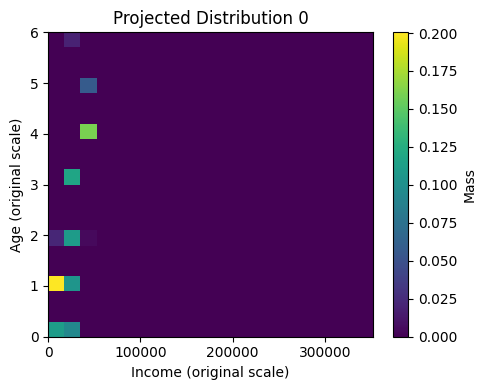

In [11]:
i = np.random.randint(0, len(distributions) - 1)
print(f"Visualizing distribution for IRIS index {i}")
plot_projected_distributions(
    distributions[i],
    grid_shape=(20, 20),
    support_min=support_min,
    support_max=support_max
)

# Clustering

In [12]:
data = distributions
n_clusters = 3
random_state = 42
reg = 1e-1

n_samples, n_bins = data.shape
rng = np.random.default_rng(random_state)

cost_matrix = ot.dist(grid, grid)

## Introduction to Wasserstein K-means

### Distance in the Wasserstein space

We now aim to cluster the IRIS units based on the joint distributions constructed earlier.

To apply a K-means algorithm to this type of data, we need a meaningful distance between distributions.  
We choose the Earth Mover’s Distance (EMD), which corresponds to the 1-Wasserstein distance. It naturally arises from the Kantorovich formulation of the optimal transport problem:

$$
\min_{\pi \in \mathbb{R}_+^{n \times m}} \sum_{i=1}^n \sum_{j=1}^m \pi_{ij} M_{ij}
\quad \text{subject to} \quad
\sum_j \pi_{ij} = a_i,\quad
\sum_i \pi_{ij} = b_j
$$

Where:

- $\pi$ is the transport plan between distributions $a$ and $b$
- $M_{ij}$ is the cost of transporting one unit of mass from point $i$ to point $j$
- $a$ and $b$ are probability distributions supported on $n$ and $m$ points, respectively

The result of this optimization is the minimal total cost of transporting the mass from $a$ to $b$, and defines the Wasserstein distance $W_1(a, b)$.

In our case, each distribution is defined over a common 2D grid (age × income), and we use this fixed support to compute pairwise distances.

This distance is easily computable using the [POT library](https://pythonot.github.io/), via:

```python
cost = ot.emd2(a, b, M)
````

Where:

* `a` and `b` are 1D probability vectors (flattened distributions on the grid), with non-negative entries summing to 1
* `M` is a cost matrix of shape `(n, n)` where `M[i, j]` is the ground cost between grid points `i` and `j`



### Cost matrix for Wasserstein distance

Since all our distributions have been projected onto a common 2D grid (age × income), they share the same discrete support.  
Each bin corresponds to a pair of indices $(\text{age\_idx}, \text{income\_idx})$, and this fixed structure allows us to define a single cost matrix for all pairwise distance computations.

We define the ground cost as the Euclidean distance between bins on the grid:

```python
coords = [(i, j) for i in range(20) for j in range(20)]
cost_matrix = ot.dist(coords, coords)
````

This cost matrix represents the transport cost between all pairs of bins. Since the grid is shared across all IRIS distributions, we only need to compute this matrix once.

As is standard in optimal transport, the cost matrix is entirely independent of the specific distributions. It depends only on how we define the locations of the support bins.

## Clustering based on barycenters (B-WKM)

### Explanation

This **centroid-based Wasserstein K-means** extends the classical Lloyd’s K-means to the space of probability measures by replacing Euclidean centroids and norms with **Wasserstein barycenters** and $W_2^2$ distances. As outlined by Domazakis et al. (2019) and formalized by Zhuang et al. (2022), the algorithm iteratively alternates between assignment and update (see below).

In [13]:
# Initialize barycenters randomly
indices = rng.choice(n_samples, size=n_clusters, replace=False)
barycenters = data[indices].copy()

* **Assignment step**: at each iteration, assign each distribution $\mu_i$ to the cluster whose centroid (a Wasserstein barycenter $\nu_k$) minimizes $W_2(\mu_i, \nu_k)$.

In [14]:
distances = np.array([
    [ot.emd2(data[i], barycenters[k], cost_matrix) for k in range(n_clusters)]
    for i in tqdm(range(n_samples), desc="Assigning to barycenters")
])
assignments = distances.argmin(axis=1)


Assigning to barycenters:   0%|          | 0/14703 [00:00<?, ?it/s]

> *Note:* For improved performance, a parallelized version of this step is used in the complete `bary_WKM` algorithm. It leverages `joblib` to compute distances concurrently.

* **Centroid update step**: recompute each cluster’s centroid as the Wasserstein barycenter of all $\mu_i$ in that cluster—i.e., solve 

$$
\nu_k = \arg \min_{\nu} \frac 1 {|G_k|} \sum_{i \in G_k} W_2^2(\mu_i,\nu)
$$


In [15]:
barycenters = []
for k in tqdm(range(n_clusters), desc="Computing barycenters"):
    indices_k = np.where(assignments == k)[0]
    if len(indices_k) == 0:
        # Empty cluster: reinitialize barycenter randomly
        rng_k = np.random.default_rng(seeds[k])
        barycenters.append(data[rng_k.integers(0, n_samples)])
    else:
        # Extract histograms for cluster k (shape: n_bins x n_samples_in_cluster)
        cluster_hists = data[indices_k].T
        # Compute Wasserstein barycenter with entropic regularization
        bary = ot.bregman.barycenter(cluster_hists, cost_matrix, reg)
        barycenters.append(bary)


Computing barycenters:   0%|          | 0/3 [00:00<?, ?it/s]

> **Note:** We also use a parallelized version of this step in the complete `bary_WKM` algorithm. It leverages `joblib` to compute each barycenter concurrently and improve performance.
>
> To ensure reproducibility across processes, we do **not** reuse a shared `rng` (which isn’t process-safe). Instead, we pre-generate a list of random seeds. Each process then creates its own local RNG using its assigned seed, ensuring both randomness and determinism. This avoids subtle bugs that can arise when sharing random state across parallel workers.


While intuitive, this method can suffer from irregularity and instability in barycenters due to the non‑Euclidean curvature of Wasserstein space, which may lead to poor cluster representation and convergence issues.

### Results

In [16]:
assignments, barycenters = bary_WKMeans(
    data=distributions,
    grid=grid,
    n_clusters=2,
    n_iter=100,
    reg=1e-1,
    random_state=None
)

Wasserstein K-Means iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Converged at iteration 7


In [17]:
for i, b in enumerate(barycenters):
    print(f"--- Barycentre {i} ---")
    print(f"Shape: {b.shape}")
    print(f"Min: {b.min():.2e}")
    print(f"Max: {b.max():.2e}")
    print(f"Sum: {b.sum():.6f}")
    print(f"Contains NaN: {np.isnan(b).any()}")
    print(f"Zero elements: {np.sum(b == 0)} / {b.size}")
    print()


--- Barycentre 0 ---
Shape: (400,)
Min: 9.04e-07
Max: 7.87e-03
Sum: 1.000000
Contains NaN: False
Zero elements: 0 / 400

--- Barycentre 1 ---
Shape: (400,)
Min: 8.13e-07
Max: 9.71e-03
Sum: 1.000000
Contains NaN: False
Zero elements: 0 / 400



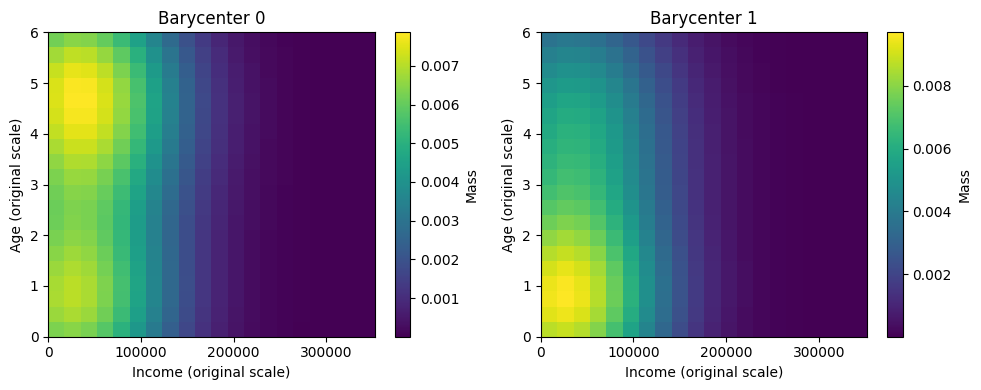

In [18]:
plot_projected_distributions(
    distributions=barycenters, 
    grid_shape=(20,20), 
    support_min=support_min, 
    support_max=support_max, 
    title="Barycenter")

### Elbow Method

To choose an appropriate number of clusters, we apply the Elbow Method.  
We run the `bary_WKMeans` algorithm for varying values of $k$, and record the total within-cluster Wasserstein distance (inertia).  
The goal is to identify a value of $k$ beyond which the inertia decreases more slowly, forming an “elbow” in the plot.


In [19]:
# Range of k values to test
k_values = range(1, 7)

inertias = []
for k_test in tqdm(k_values, desc="Running Elbow Method"):
    # Run barycentric Wasserstein K-Means
    assignments, barycenters = bary_WKMeans(
        data=distributions,
        grid=grid,
        n_clusters=k_test,
        n_iter=100,
        reg=1e-1,
        random_state=42
    )

    # Compute inertia as the sum of squared Wasserstein distances
    inertia_values = Parallel(n_jobs=-1)(
        delayed(ot.emd2)(
            distributions[i],
            barycenters[assignments[i]],
            cost_matrix
        )
        for i in range(len(distributions))
    )

    total_inertia = np.sum(inertia_values)
    inertias.append(total_inertia)

Running Elbow Method:   0%|          | 0/6 [00:00<?, ?it/s]

Wasserstein K-Means iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Converged at iteration 1


Wasserstein K-Means iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Converged at iteration 9


Wasserstein K-Means iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Converged at iteration 9


Wasserstein K-Means iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Converged at iteration 17


Wasserstein K-Means iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Converged at iteration 25


Wasserstein K-Means iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Converged at iteration 81


In [20]:
# [np.float64(707.3260129549708), np.float64(659.0284519245866), np.float64(658.8780941565043), np.float64(658.7754832723086), np.float64(658.7242441476094), np.float64(658.7667609439678), np.float64(697.5709090458654), np.float64(657.5878991548839), np.float64(654.2048632599021), np.float64(652.6456142450841)]
# [np.float64(707.3260129549708), np.float64(659.0284519245866), np.float64(658.8780941565043), np.float64(658.7754832723086), np.float64(658.7242441476094), np.float64(658.7667609439678), np.float64(698.7399500659517)]
print(inertias)

[np.float64(707.3260129549708), np.float64(659.0284519245866), np.float64(658.8780941565043), np.float64(658.7754832723086), np.float64(658.7242441476094), np.float64(658.7667609439678)]


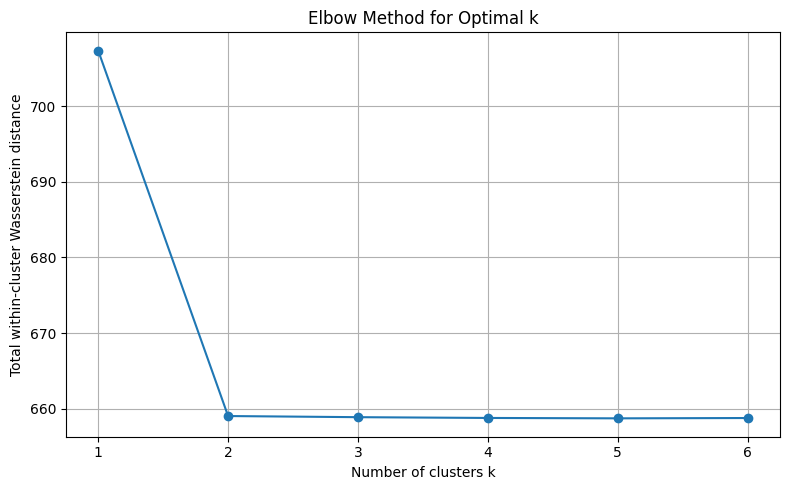

In [21]:
# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values[:len(inertias)], inertias, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters k")
plt.ylabel("Total within-cluster Wasserstein distance")
plt.grid(True)
plt.tight_layout()
plt.show()

The elbow plot shows a sharp drop between 1 and 2 clusters, then a plateau. This suggests that most of the clustering gain is achieved with **k = 2**, making it a natural choice according to the elbow method.


## Clustering based on pairwise distances (D-WKM)

### Explanation

As an alternative to the centroid-based Wasserstein K-means, we implement a **distance-based variant** of the algorithm, inspired by the classical Euclidean K-means formulation based solely on intra-cluster pairwise distances.

The objective function we minimize is:

$$
\min_{G_1, \dots, G_K} \left\{ \sum_{k=1}^K \frac{1}{|G_k|} \sum_{i,j \in G_k} W_2^2(\mu_i, \mu_j) \; : \; \bigsqcup_{k=1}^K G_k = [n] \right\}
$$

Instead of updating cluster centroids, the algorithm reassigns each distribution to the cluster where its average squared Wasserstein distance to all current members is minimal.

Importantly, the pairwise distances between distributions are **fixed** throughout the algorithm. To avoid redundant computations at each iteration, we precompute all $W_2^2$ distances and store them in a matrix. This distance matrix encodes the squared Wasserstein distances between every pair of input distributions.

In [22]:
pairwise = computeDistanceMatrix(
    data = distributions,
    grid = grid,
    save=True,
    filepath='../data/Dis_mat_france.txt'
)

Pairwise distance matrix saved to: ../data/Dis_mat_france.txt


If the matrix has already been computed and saved, we can simply reload it:

In [23]:
pairwise = np.loadtxt("../data/Dis_mat_france.txt", dtype=float)

The algorithm lies in a simple iterative procedure:

* Start with an initial partition of the data into $K$ clusters.

In [24]:
# Initialize assignments randomly
assignments = rng.integers(0, n_clusters, size=n_samples)

* At each iteration, reassign each distribution $\mu_i$ to the cluster $G_k$ that minimizes its average squared distance to the current members of $G_k$.

In [25]:
# Initialize the new assignments array
new_assignments = np.zeros_like(assignments)

for i in range(n_samples):
    avg_dists_to_clusters = []

    for k in range(n_clusters):
        # Get indices of current members of cluster k
        members_k = np.where(assignments == k)[0]

        if len(members_k) == 0:
            # Avoid assigning to empty clusters
            avg_distance = np.inf
        else:
            # Compute average squared Wasserstein distance to cluster k
            distances = [pairwise[i, j] for j in members_k]
            avg_distance = np.mean(distances)

        avg_dists_to_clusters.append(avg_distance)

    # Assign distribution i to the closest cluster
    new_assignments[i] = np.argmin(avg_dists_to_clusters)


> **Note:** This is a simplified version for clarity. The actual implementation uses a more efficient vectorized strategy to compute average distances without looping over clusters inside the main loop.


Unlike the centroid-based version, this algorithm doesn’t compute or require barycenters at any step, making it more stable and scalable when working with a large number of high-dimensional or irregular distributions.

### Results

In [26]:
assignments = dist_WKMeans(
    data = distributions,
    grid = grid,
    dist_matrix=pairwise,
    n_clusters=3,
    n_iter=100,
    random_state=None
)

Wasserstein pairwise clustering iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Converged at iteration 37


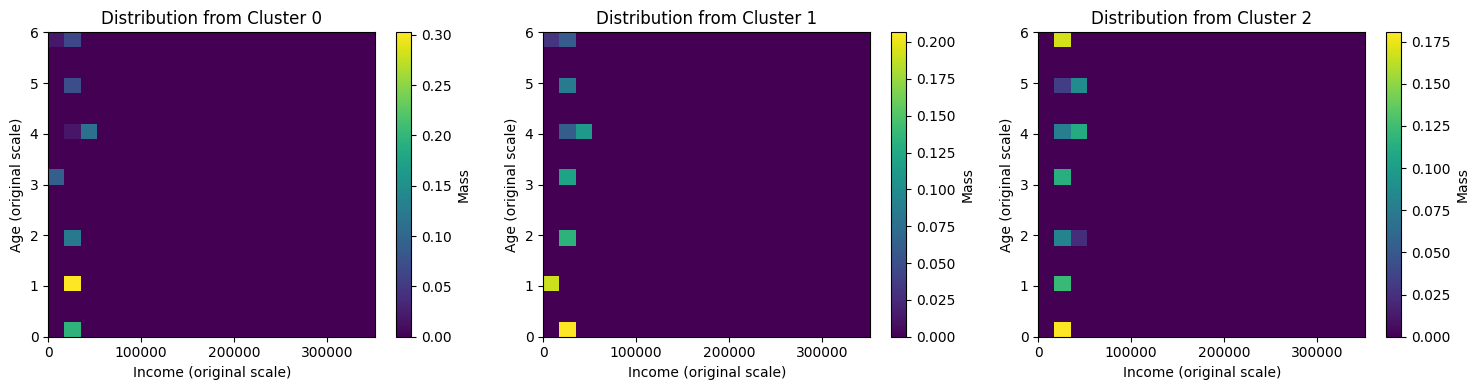

In [27]:
indices = [np.where(assignments == k)[0][0] for k in range(n_clusters)]
plot_projected_distributions(
    [distributions[i] for i in indices],
    grid_shape=(20, 20),
    support_min=support_min,
    support_max=support_max,
    title='Distribution from Cluster'
)

### Elbow Method

In [28]:
k_values = range(1, 7)

inertias = []
for k_test in tqdm(k_values):
    assignments = dist_WKMeans(
        data=distributions,
        grid=grid,
        dist_matrix=pairwise,
        n_clusters=k_test,
        n_iter=1000,
        random_state=42
    )

    # Generate new seeds for barycenters
    seeds = rng.integers(0, 1e9, size=k_test)

    # Barycenter update step (parallelized with independent seeds)
    barycenters = Parallel(n_jobs=-1)(
        delayed(compute_barycenter_for_cluster)(
            k, assignments, data, cost_matrix, reg, seeds[k]
        )
        for k in range(k_test)
    )

    inertia_values = Parallel(n_jobs=-1)(
        delayed(ot.emd2)(
            distributions[i],
            barycenters[assignments[i]],
            cost_matrix
        )
        for i in range(n_samples)
    )

    inertias.append(np.sum(inertia_values))


  0%|          | 0/6 [00:00<?, ?it/s]

Wasserstein pairwise clustering iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Converged at iteration 0


Wasserstein pairwise clustering iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Converged at iteration 12


Wasserstein pairwise clustering iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Converged at iteration 24


Wasserstein pairwise clustering iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Converged at iteration 32


Wasserstein pairwise clustering iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Converged at iteration 45


Wasserstein pairwise clustering iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Converged at iteration 58


In [29]:
print(inertias)
#[np.float64(707.3260129549699), np.float64(655.2251128337183), np.float64(640.3128525906923), np.float64(633.8249049346546), np.float64(630.4182823342658), np.float64(628.3389692216414)]

[np.float64(707.326012954971), np.float64(655.2251128337184), np.float64(640.312852590692), np.float64(633.8249049346546), np.float64(630.4182823342658), np.float64(628.3389692216413)]


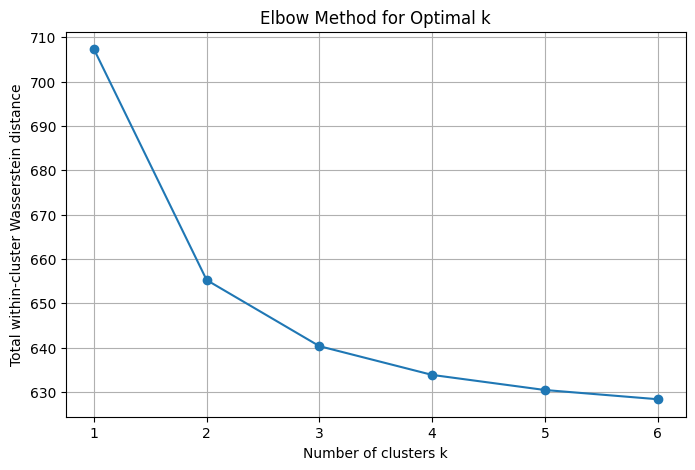

In [30]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters k")
plt.ylabel("Total within-cluster Wasserstein distance")
plt.grid(True)
plt.show()

The inertia curve decreases steadily, without a clear elbow, suggesting that adding clusters continues to improve the fit up to at least k = 5 or 6. This contrasts with the curved of bary_WKM, which showed a sharp drop followed by a plateau at k = 2 : a value that may underestimate the complexity of joint age-income distributions.

# Mapping

In [38]:
# Compute assignments with pairwise distance method
assignments = dist_WKMeans(data = distributions, grid = grid, dist_matrix=pairwise, n_clusters=3, n_iter=100, random_state=None)

Wasserstein pairwise clustering iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Converged at iteration 25


IRIS are above all geographical areas of France, that is why in this section we will try to understand the spatial structure underlying our clustering results. We visualize the IRIS regions colored by their cluster assignments, first on a national scale, then focusing on Paris, to identify spatial patterns in the joint income-age distributions.

We use the distance-based Wasserstein K-means (dist\_WKM) rather than the centroid-based version (bary\_WKM), as it produces more stable and interpretable clusters. In particular, its elbow curve suggests a richer and more nuanced structure, whereas bary\_WKM tends to collapse the data into very few clusters (k = 2), which appears too coarse to capture the complexity of the joint distributions.

We begin with a map of France, then zoom in on Paris to reveal more local dynamics.

## France

We first note that income-age joint distributions are available for only a subset of IRIS regions: 14,703 out of 48,569. As a result, we begin by filtering the national IRIS shapefile to retain only those regions for which we have usable data. We then assign cluster labels to these IRIS and visualize the spatial structure of the Wasserstein K-means clustering across France.

In [39]:
# Load full IRIS shapefile (includes all IRIS regions in France)
gdf_france_raw = gpd.read_file("../data/contours-iris.gpkg")

# Convert IRIS codes to string to match format
gdf_france_raw["code_iris"] = gdf_france_raw["code_iris"].astype(str)

# Create dataframe with cluster assignments
iris_cluster_df = pd.DataFrame({
    "code_iris": common_iris,
    "cluster": assignments
})

# Merge: keep all IRIS regions, cluster info where available
gdf_france = gdf_france_raw.merge(iris_cluster_df, on="code_iris", how="left")

# Ensure cluster is treated as a categorical variable
gdf_france["cluster"] = gdf_france["cluster"].astype("category")

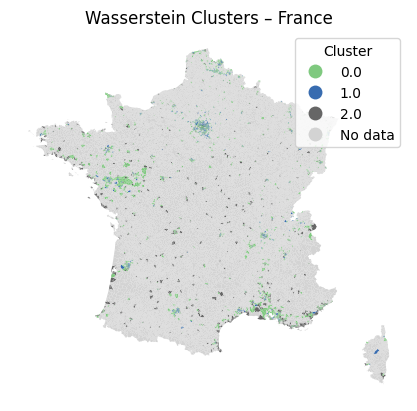

In [40]:
# Plot the map
gdf_france.plot(
    column="cluster",
    cmap="Accent",
    legend=True,
    legend_kwds={"title": "Cluster"},
    missing_kwds={"color": "lightgrey", "label": "No data"}
)
plt.title("Wasserstein Clusters – France")
plt.axis("off")
plt.show()

The relatively small number of IRIS units for which we have income distributions limits the interpretability of the clustering map at the national level. As a result, we focus next on Paris, where the density of available data is much higher and spatial patterns are easier to observe.

## Paris

For Paris, our analysis is divided into two steps: 
- firstly, we compute a clustering restricted to Parisian IRIS in order to capture local structures;
- secondly, we project the national clustering onto Paris to see how global patterns translate at the city level.

To make this comparison, we prepare a merged dataset that contains both the Paris-specific and national cluster assignments.

In [41]:
# Computation of the clustering restricted to Parisian IRIS

iris_paris = [iris for iris in common_iris if iris.startswith("75")]
distributions_paris = np.array([distributions[common_iris.index(iris)] for iris in iris_paris])

pairwise_paris = computeDistanceMatrix(
    data = distributions_paris,
    grid = grid,
    save=True,
    filepath='../data/Dis_mat_paris.txt'
)

pairwise_paris = np.loadtxt("../data/Dis_mat_paris.txt", dtype=float)

assignments_paris = dist_WKMeans(
    data = distributions_paris,
    grid = grid,
    dist_matrix=pairwise_paris,
    n_clusters=3,
    n_iter=40,
    random_state=None
)

Pairwise distance matrix saved to: ../data/Dis_mat_paris.txt


Wasserstein pairwise clustering iterations:   0%|          | 0/40 [00:00<?, ?it/s]

Converged at iteration 10


In [42]:
# Creation of the common gdf

assignments_proj = np.array([assignments[common_iris.index(iris)] for iris in iris_paris])

gdf_paris = gdf_france_raw[gdf_france_raw["code_iris"].isin(iris_paris)].copy()

iris_cluster_df = pd.DataFrame({
    "code_iris": iris_paris,
    "cluster_proj": assignments_proj,
    "cluster_paris": assignments_paris
})

gdf_paris = gdf_paris.merge(iris_cluster_df, on="code_iris", how="left")

gdf_paris['cluster_proj'] = gdf_paris['cluster_proj'].astype('category')
gdf_paris['cluster_paris'] = gdf_paris['cluster_paris'].astype('category')


### France clustering projected on Paris

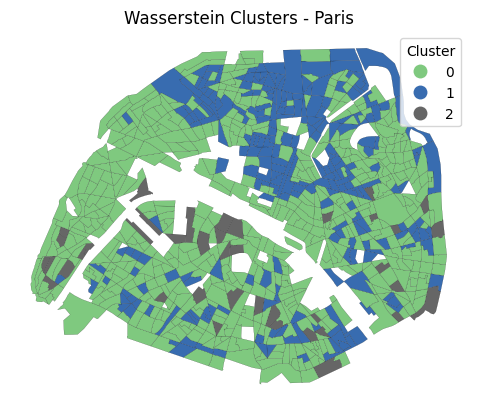

In [43]:
gdf_paris.plot(
    column='cluster_proj',
    cmap='Accent',
    legend=True,
    legend_kwds={'title': 'Cluster'},
    edgecolor='black',
    linewidth=0.1,
    missing_kwds={'color': 'lightgrey', 'label': 'No data'}
)
plt.title("Wasserstein Clusters - Paris")
plt.axis('off')
plt.show()


### Paris Clustering

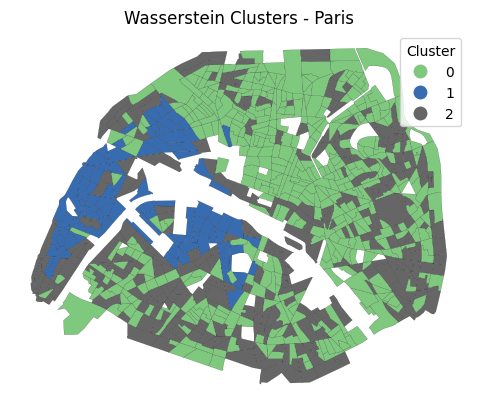

In [44]:
gdf_paris.plot(
    column='cluster_paris',
    cmap='Accent',
    legend=True,
    legend_kwds={'title': 'Cluster'},
    edgecolor='black',
    linewidth=0.1,
    missing_kwds={'color': 'lightgrey', 'label': 'No data'}
)
plt.title("Wasserstein Clusters - Paris")
plt.axis('off')
plt.show()


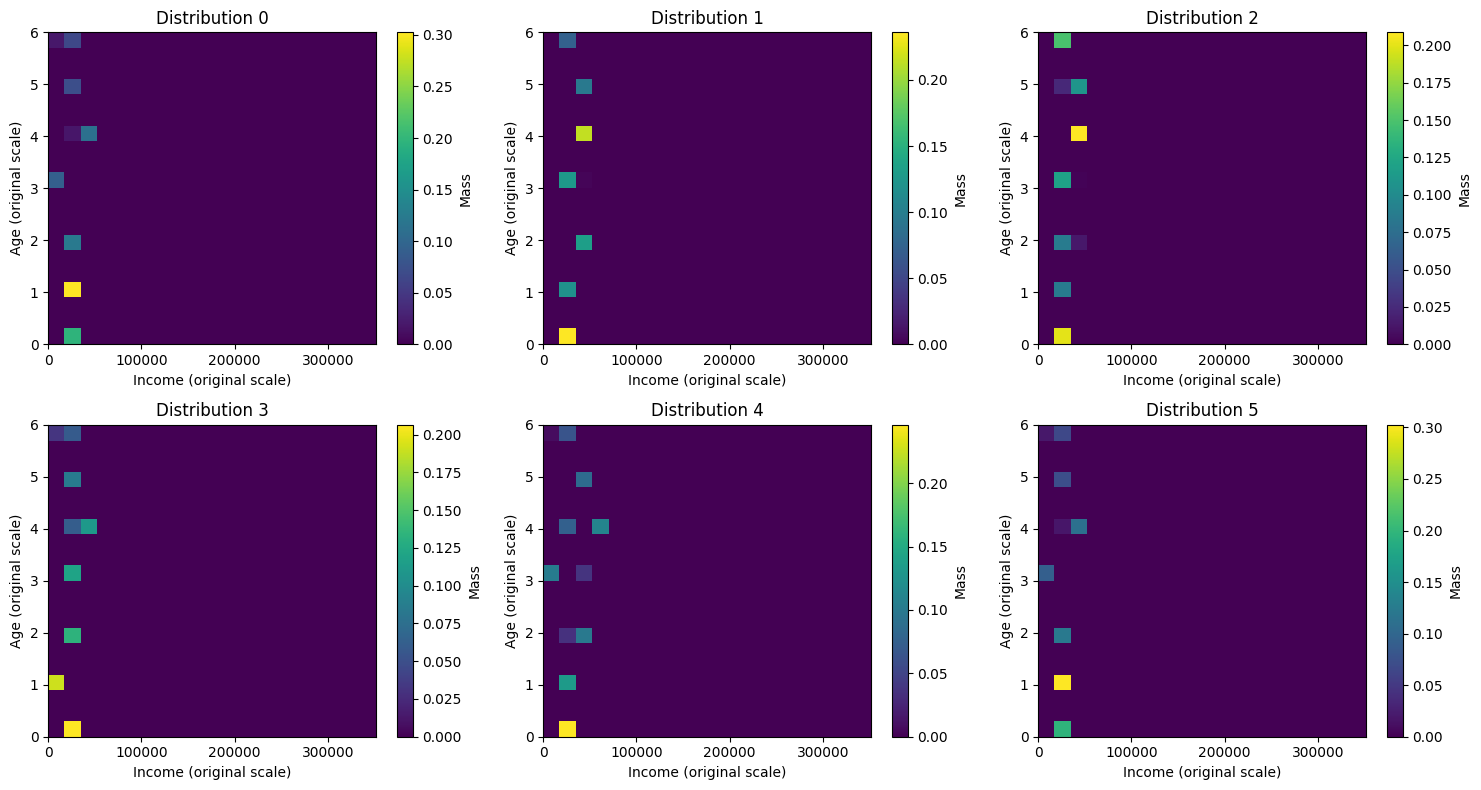

In [47]:
proj_idx = [np.where(assignments_proj == k)[0][0] for k in range(3)]
par_idx = [np.where(assignments_paris == k)[0][0] for k in range(3)]
indices = proj_idx + par_idx

plot_projected_distributions(
    [distributions[i] for i in indices],
    grid_shape=(20, 20),
    support_min=support_min,
    support_max=support_max,
    title='Distribution'
)